In [1]:
import os
import numpy as np
import torch
import mdtraj as md
import torch.nn as nn
import torch.nn.functional as F
import deeptime
from torch.utils.data import DataLoader
from tqdm import tqdm
# helpful neuron functions
# numpy arrays as inputs
def dif(x1,x2):
    return np.sqrt(np.sum((x1-x2)**2))

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")
torch.set_num_threads(12)


In [26]:
import numpy as np
import mdtraj as md
import matplotlib.pyplot as plt
import nglview as nv

In [3]:
!find ~/Downloads $(pwd) -type f | grep enhanced

/Users/tommysisk/Downloads/enhanced_path_frames.pdb
/Users/tommysisk/Downloads/enhanced_path_frames (1).pdb


In [43]:
print(trj)

<mdtraj.Trajectory with 643 frames, 21 atoms, 21 residues, and unitcells>


In [2]:
pdb = "/Users/tommysisk/Downloads/enhanced_path_frames.pdb"
top = md.load(pdb)
top.center_coordinates()
top = top.atom_slice(top.topology.select("name CA and chainid != 0"))
c = top.xyz
# table,bonds=top.to_dataframe()
# table[table["chainID"]>2] = 0
# table[table["chainID"]==2] = 1
# top = md.Topology.from_dataframe(table, bonds)

In [3]:
trj = top
CAatoms=trj.topology.select("all")
CAdihe_index=[]
CAlabel=[]
CAang_index=[]
CAvec_index=[]
CApos=c

for i in range(0,len(CAatoms)):
     CAlabel.append(trj.topology.atom(CAatoms[i]).residue.resSeq)

print(np.array(CAlabel).astype(int))

def writhe_matrix(segment1,segment2):
 v13 = s2[:,0] - s1[:,0]
 v23 = s2[:,0] - s1[:,1]
 v24 = s2[:,1] - s1[:,1]
 v14 = s2[:,1] - s1[:,0]
 v = [v13,v23,v24,v14,v13,v23]
 e = []
 l13 = np.linalg.norm(v13,axis=1)
 l23 = np.linalg.norm(v23,axis=1)
 l24 = np.linalg.norm(v24,axis=1)
 l14 = np.linalg.norm(v14,axis=1)
 ls = [l13,l23,l24,l14]   
 for l in ls:
        if np.sum(l) == 0.0:
            return 0
 e13 = v13/l13[:,None]
 e23 = v23/l23[:,None]
 e24 = v24/l24[:,None]
 e14 = v14/l14[:,None]
 e = [e13,e23,e24,e14,e13,e23] 
    #compute the angles
 s = 0
 for i in range(1,len(e)-1):
        a = np.asarray(e[i-1])
        b =np.asarray(e[i])
        c = np.asarray(e[i+1])
        #a =e[i-1]
        #b =e[i]
        #c = e[i+1]
        v1=a-b
        v3=c-b
        #a=np.dot(v1,v3)
        a=(v1*v3).sum(axis=1)/(np.linalg.norm(v1,axis=1)*np.linalg.norm(v3,axis=1))
        #a=np.dot(v1,v3)/(np.linalg.norm(v1,axis=1)*np.linalg.norm(v3,axis=1))
        theta=np.arccos(np.clip(a, -1.0, 1.0))  
        s = s +theta
 w = np.sign(s)*2*np.pi - s
 return w

def get_segments(segment1,segment2):
    '''Compute writhe contribution from two input [x,y,z] cooridnate pairs'''
    s1 = segment1
    #print("s1:",s1)
    s2 = segment2
    #print("s2:",s2)
    #form unit vectors at the segment extremes:
    v13 = s2[0] - s1[0]
    v23 = s2[0] - s1[1]
    v24 = s2[1] - s1[1]
    v14 = s2[1] - s1[0]
    #print("v13:",v13)
    #print("v23:",v23)
    #print("v24:",v24)
    #print("v14:",v14)
    v = [v13,v23,v24,v14,v13,v23]
    e = []
    l13 = np.linalg.norm(v13)
    l23 = np.linalg.norm(v23)
    l24 = np.linalg.norm(v24)
    l14 = np.linalg.norm(v14)
    ls = [l13,l23,l24,l14]
    #print("ls:",ls)
    for l in ls:
        if l == 0.0:
            return 0
    e13 = v13/l13
    e23 = v23/l23
    e24 = v24/l24
    e14 = v14/l14
    e = [e13,e23,e24,e14,e13,e23]    
    #print("e:",np.shape(e),e)
    s = 0
    #this is an integral
    for i in range(1,len(e)-1):
        a = e[i-1]
        b =e[i]
        c = e[i+1]
        v1=a-b
        v3=c-b
        #print("v1",np.shape(v1),v1)
        #print("v3",np.shape(v3),v3)
        a=np.dot(v1,v3)
        #print("Segment","i",i,"a",np.shape(a),a)
        a=np.dot(v1,v3)/(np.linalg.norm(v1)*np.linalg.norm(v3))
        theta=np.arccos(np.clip(a, -1.0, 1.0))  
        s = s +theta
        #print("s:",s)
    w = np.sign(s)*2*np.pi - s
    print("w:",w)
    return
get_segments([CApos[0][0],CApos[0][1]],[CApos[0][2],CApos[0][3]])
get_segments([CApos[1][0],CApos[1][1]],[CApos[1][2],CApos[1][3]])

#Collect CA Positions
v1=CApos[:,0]
v2=CApos[:,1]
v3=CApos[:,2]
v4=CApos[:,3]


#Put positions in array of dimensions Framesx2x3 - Row=[[x,y,z][x,y,z]]
s1=np.empty((len(CApos),2,3))
s2=np.empty((len(CApos),2,3))
s1[:,0]=v1
s1[:,1]=v2
s2[:,0]=v3
s2[:,1]=v4
w_all=writhe_matrix(s1,s2)
print("w_all:",w_all)

[484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501
 502 503 504]
w: 0.10092808469016035
w: 0.00030365766085793666
w_all: [1.00928078e-01 3.03651913e-04 2.70122273e-02 1.31389558e-02
 2.92449729e-01 7.66642056e-02 8.10020924e-02 1.80350615e-01
 1.24914821e-01 2.59696167e-02 1.43513537e-01 1.96222827e-01
 1.14730714e-02 3.89218632e-01 1.04579489e-01 4.25947050e-02
 1.04704737e-03 7.80027674e-03 1.30306392e-01 3.71204511e-03
 8.18470999e-02 4.44574169e-02 5.06039511e-03 4.69714131e-03
 1.66890766e-01 4.65474676e-01 4.11719222e-03 1.08219701e-01
 3.14464093e-01 6.80346003e-03 1.45314481e-01 1.66209550e-02
 7.34474429e-03 1.31686913e-01 8.80486809e-01 4.07097908e-02
 6.37631139e-03 6.74180802e-01 8.96508940e-02 4.75023501e-01
 5.43452813e-04 3.91674396e-04 3.88219315e-02 3.92315909e-01
 8.25666979e-03 2.36558039e-01 2.43075162e-01 3.62663132e-01
 2.83314422e-02 1.57958354e-01 5.47309627e-01 2.37739892e-02
 1.69656947e-01 1.02492655e+00 7.16097853e-01 3.40404588e-01
 9.

sel_ = [[i + j for i in range(4)] for j in range(dim)]

In [6]:
dim =21
wr_total={}
for j in range(0,len(CAlabel)-1):
 wr_total[j]={}
 v1=CApos[:,j]; v2=CApos[:,j+1];
 s1=np.empty((len(CApos),2,3))
 s1[:,0]=v1
 s1[:,1]=v2
 for k in range(j+1,len(CAlabel)-1):
      v3=CApos[:,k]; v4=CApos[:,k+1];
      s2=np.empty((len(CApos),2,3))
      s2[:,0]=v3
      s2[:,1]=v4
      wr_total[j][k]=writhe_matrix(s1,s2)

writhe_by_res={}
wtot=np.zeros(len(CApos[:,0]))
for i in wr_total:
    w=np.zeros(len(CApos[:,0]))
    for j in wr_total[i]:
       w+=wr_total[i][j] 
    writhe_by_res[i]=w
    wtot+=w
#Sum over all pairs - not just the top half of the matrix
wr_total={}
for j in range(0,len(CAlabel)-1):
 wr_total[j]={}
 v1=CApos[:,j]; v2=CApos[:,j+1];
 s1=np.empty((len(CApos),2,3))
 s1[:,0]=v1
 s1[:,1]=v2
 for k in range(0,len(CAlabel)-1):
      v3=CApos[:,k]; v4=CApos[:,k+1];
      s2=np.empty((len(CApos),2,3))
      s2[:,0]=v3
      s2[:,1]=v4
      wr_total[j][k]=writhe_matrix(s1,s2)

writhe_by_res={}
wtot=np.zeros(len(CApos[:,0]))
for i in wr_total:
    w=np.zeros(len(CApos[:,0]))
    for j in wr_total[i]:
       w+=wr_total[i][j] 
    writhe_by_res[i]=w
    wtot+=w
wmat = np.zeros((trj.n_frames,1, dim-1, dim-1))
for i in range(dim-1):
    for j in range(dim-1):
        wmat[:,0,i,j] = wr_total[i][j]
    

In [46]:
wmat.shape

(643, 1, 20, 20)

In [42]:
trj.n_frames/7

91.85714285714286

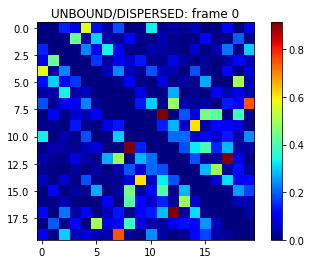

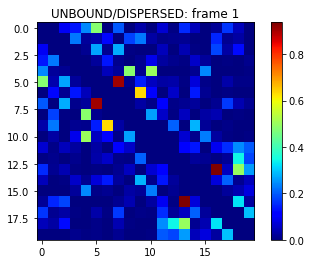

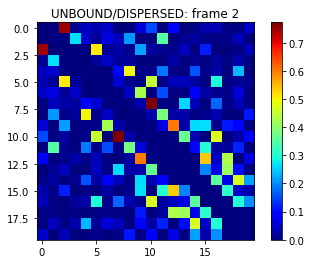

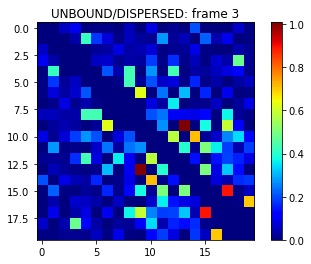

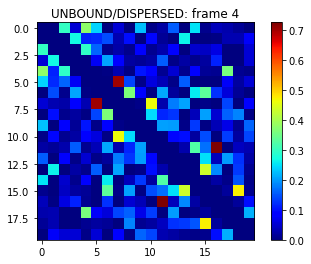

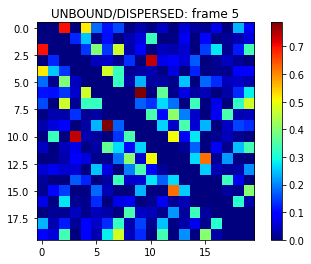

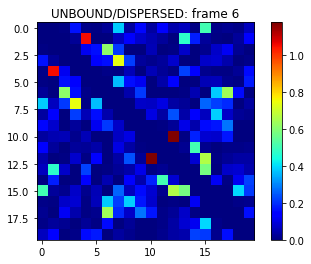

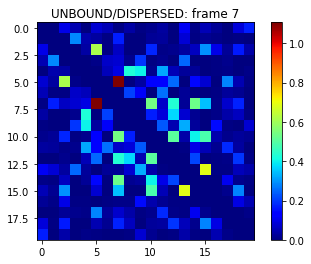

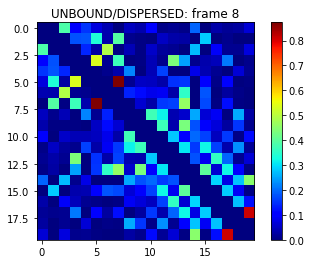

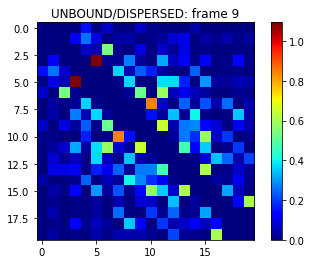

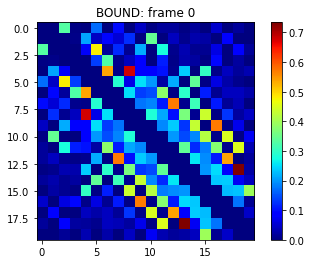

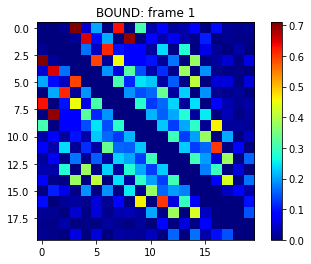

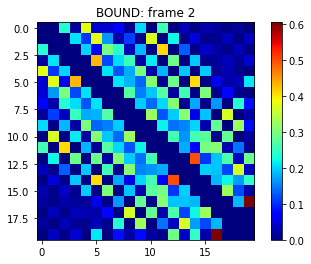

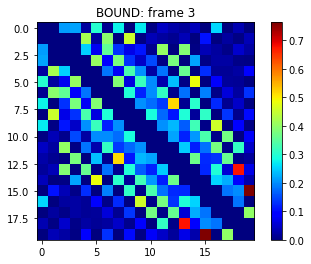

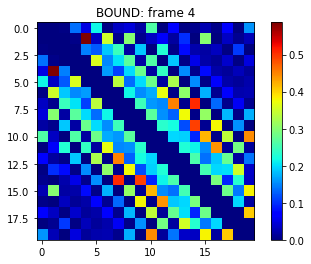

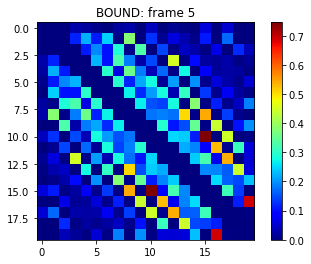

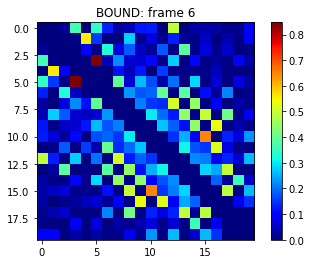

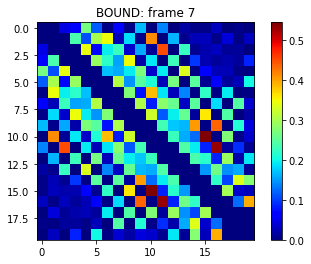

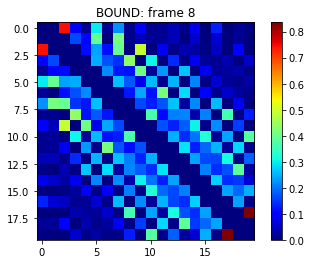

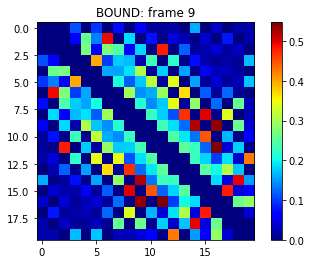

In [59]:
frames = np.arange(trj.n_frames)
frames = frames[110:120].tolist()+frames[-10:].tolist()
for i in frames:
    plt.figure()
    if i>119:
        plt.title(f"BOUND: frame {i-(len(wmat)-10)}")
    else:
        plt.title(f"UNBOUND/DISPERSED: frame {i-10)}")
    plt.imshow(wmat[i][0], cmap = "jet")
    plt.colorbar()

In [52]:
##Bound
view = nv.show_mdtraj(top[-10:])
view.clear_representations()
view
view.clear_representations()
view.add_ribbon(color="red",opacity=1)
view.add_licorice("0", color = "blue")
view

NGLWidget(max_frame=9)

In [54]:
#~
view = nv.show_mdtraj(top[110:120])
view.clear_representations()
view.add_ribbon(color="red",opacity=1)
view.add_licorice("20")
view

NGLWidget(max_frame=9)

In [8]:
#nn module for VAMPnet 
class wnet(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,2)
        self.conv2 = nn.Conv2d(32,64,2)
        self.conv3 = nn.Conv2d(64,128,4)
        self.conv4 = nn.Conv2d(128,256,4)
        self.to_linear = None
        x = torch.randn(dim,dim).view(-1,1,dim,dim)
        self.convs(x)
        print(self.to_linear)
        self.lin = nn.Sequential(
            nn.Linear(self.to_linear, int(self.to_linear*.8)),
            nn.ReLU(inplace=True),
            nn.Linear(int(self.to_linear*.8),int(self.to_linear*.5)),
            nn.ReLU(inplace=True), 
            nn.Linear(int(self.to_linear*.5),10),
            nn.Softmax(dim=1)
            )
    def convs(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(F.relu(self.conv3(x)),2)
        x = F.max_pool2d(F.relu(self.conv4(x)),2)
        if self.to_linear is None:
            self.to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x.view(-1,self.to_linear)
    
    def forward(self,x):
        x = self.convs(x)
        return self.lin(x)


    
r_ = 20
r = torch.rand((1,1,r_,r_))
lobe1 = wnet(r_)
print(lobe1(r))
#print(lobe2(r))

        

1024
tensor([[0.0965, 0.0964, 0.0980, 0.1022, 0.1015, 0.1006, 0.0996, 0.1035, 0.1023,
         0.0994]], grad_fn=<SoftmaxBackward0>)


In [ ]:

traj = md.load("/Users/tommysisk/projects/msms/IDP_MSM/centered_NtailXD.dcd")
bb = traj.atom_slice(traj.topology.select("protein and backbone"))

In [5]:
#calculate contacts, create 3D array of 2D images
coords = bb.xyz 
tsr = np.empty([coords.shape[i] for i in [0,1,1]])
for n,i in enumerate(coords):
    for l,j in enumerate(np.flip(i,axis=0)):
        tsr[n][l] = np.array([dif(j,k) for k in i])

In [ ]:
#plot an image
import matplotlib.pyplot as plt
plt.imshow(tsr[500],cmap="jet")
plt.colorbar(label="distance nm")
_=plt.yticks(np.arange(282)[::50],np.flip(np.arange(282)[::50]))

In [99]:
#process data
t1 = np.copy(tsr)
t1 = t1.reshape(643,1,282,282).astype(np.float32)
t1 = torch.from_numpy(t1)
t1 = t1/tsr.max()
dataset = deeptime.util.data.TrajectoryDataset(lagtime=30, trajectory=t1)
batch_size = 10
n_val = int(len(dataset)*.3)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])
loader_train = DataLoader(train_data, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

In [7]:
#create 2d convnets - either should work
#test by running random tensor through both

class wnet(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,2)
        self.conv2 = nn.Conv2d(32,64,2)
        self.conv3 = nn.Conv2d(64,128,4)
        self.conv4 = nn.Conv2d(128,256,4)
        self.to_linear = None
        x = torch.randn(dim,dim).view(-1,1,dim,dim)
        self.convs(x)
        print(self.to_linear)
        self.lin = nn.Sequential(
            nn.Linear(self.to_linear, int(self.to_linear*.8)),
            nn.ReLU(inplace=True),
            nn.Linear(int(self.to_linear*.8),int(self.to_linear*.5)),
            nn.ReLU(inplace=True), 
            nn.Linear(int(self.to_linear*.5),10),
            nn.Softmax(dim=1)
            )
    def convs(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(F.relu(self.conv3(x)),2)
        x = F.max_pool2d(F.relu(self.conv4(x)),2)
        if self.to_linear is None:
            self.to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x.view(-1,self.to_linear)
    
    def forward(self,x):
        x = self.convs(x)
        return self.lin(x)


    
r_ = 20
r = torch.rand((1,1,r_,r_))
lobe1 = wnet(r_)
print(lobe1(r))
#print(lobe2(r))

        

1024
tensor([[0.1035, 0.0991, 0.0948, 0.1026, 0.0981, 0.0970, 0.0988, 0.1056, 0.0980,
         0.1023]], grad_fn=<SoftmaxBackward0>)


In [39]:
int(1024*.2)

204

In [90]:
#example of how conv works
## (kernel size -1) is the amount the output image is reduced
r_ = 20
testConv = nn.Conv2d(1,32,2, padding = 0, stride=0)
testPool = nn.MaxPool2d(kernel_size=(2,2), stride = 1)
r = torch.rand((1,1,r_,r_))
print(test(r).shape)
print(testPool(test(r)).shape)

NameError: name 'nn' is not defined

In [16]:
21**2

441

In [101]:
#run data through convnet to check 
lobe1(t1[::100])

tensor([[0.0988, 0.0987, 0.1027, 0.1038, 0.1001, 0.1015, 0.1017, 0.0983, 0.1003,
         0.0942],
        [0.0992, 0.0987, 0.1027, 0.1048, 0.0997, 0.1016, 0.1016, 0.0978, 0.1002,
         0.0937],
        [0.0990, 0.0988, 0.1027, 0.1046, 0.0996, 0.1019, 0.1018, 0.0980, 0.1001,
         0.0937],
        [0.0988, 0.0987, 0.1027, 0.1040, 0.1000, 0.1015, 0.1017, 0.0982, 0.1002,
         0.0941],
        [0.0988, 0.0987, 0.1028, 0.1038, 0.1000, 0.1015, 0.1016, 0.0984, 0.1001,
         0.0943],
        [0.0988, 0.0986, 0.1029, 0.1037, 0.1000, 0.1016, 0.1017, 0.0984, 0.1000,
         0.0944],
        [0.0988, 0.0987, 0.1028, 0.1038, 0.1000, 0.1016, 0.1016, 0.0984, 0.1001,
         0.0943]], grad_fn=<SoftmaxBackward0>)

In [103]:
#Create VAMP model, train,etc
lobe = lobe1.float()
from copy import deepcopy
lobe_timelagged = deepcopy(lobe).to(device=device)
lobe = lobe.to(device=device)
print(lobe)
from deeptime.decomposition.deep import VAMPNet
vampnet = VAMPNet(lobe=lobe,lobe_timelagged=lobe_timelagged, learning_rate=1e-3, device=device)
model = vampnet.fit(loader_train, n_epochs=10,
                    validation_loader=loader_val, progress=tqdm).fetch_model()           

Net(
  (conv1): Conv2d(1, 32, kernel_size=(6, 6), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(6, 6), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(6, 6), stride=(1, 1))
  (fc1): Linear(in_features=115200, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


KeyboardInterrupt: 

''

In [106]:
#extract probabilities
probabilities = model.transform(t1[::100])

In [107]:
##network outputs probabilistic assignments to each cluster for each frame --> Nframes by Nstates array
probabilities[0]

array([0.06600839, 0.05907963, 0.05177299, 0.01203726, 0.0134739 ,
       0.31652358, 0.08224312, 0.12066939, 0.17666093, 0.10153081],
      dtype=float32)

In [108]:
probabilities[0].sum()

1.0

In [43]:
#other networks and modules
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

class Lj(nn.Module):
    def __init__(self, shape):
        super().__init__()
    def forward(self, x):
        n = x.size
        return 
    
class convs(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,6)
        self.conv2 = nn.Conv2d(32,64,6)
        self.conv3 = nn.Conv2d(64,128,6)
    def forward(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)),(2,2))
        self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x.view(-1,self._to_linear)



class Net2(nn.Module):
    def __init__(self):
        
      super().__init__()
      self.conv1 = nn.Conv2d(1, 32, 5, 1)
      self.conv2 = nn.Conv2d(32, 64, 5, 1)
      self.conv3 = nn.Conv2d(64,128,5)
    
    
      self.dropout1 = nn.Dropout2d(0.25)
      self.dropout2 = nn.Dropout2d(0.5)
      self.fc1 = nn.Linear(9216, 128)
      self.fc2 = nn.Linear(128, 10)
    # x represents our data
    def forward(self, x):
      # Pass data through conv1
      x = self.conv1(x)
      # Use the rectified-linear activation function over x
      x = F.relu(x)

      x = self.conv2(x)
      x = F.relu(x)
      
      x = self.conv3(x)
      x = F.relu(x)

      # Run max pooling over x
      x = F.max_pool2d(x, 2)
      # Pass data through dropout1
      x = self.dropout1(x)
      # Flatten x with start_dim=1
      x = torch.flatten(x, 1)
      # Pass data through fc1
      x = self.fc1(x)
      x = F.relu(x)
      x = self.dropout2(x)
      x = self.fc2(x)

      # Apply softmax to x
      output = F.log_softmax(x, dim=1)
      return output

In [94]:
l = list(range(10))

In [95]:
l

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

False